In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.lines as mlines
import os
from google.colab import drive
from sklearn.preprocessing import LabelEncoder

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Combined Data

In [ ]:
import pandas as pd
import os
from google.colab import drive
from google.colab import files

# Path ke direktori file Excel di Google Drive
file_path = "/content/drive/MyDrive/INTERNSHIP2/DATASET/DATA MENTAH/"

# Kolom yang diambil
required_columns = [
    "nm_divre", "nm_bu", "tgl_bbk_normal", "kd_armada", "kd_item", "nm_item",
    "jumlah", "harga_satuan", "total_harga", "nm_merek_item",
    "nm_merek_armada", "umur_armada", "tahun_armada", "nm_segment"
]

all_dataframes = []

# Loop semua file di folder
for filename in os.listdir(file_path):
    if filename.lower().endswith((".xlsx", ".xls")):
        file_full_path = os.path.join(file_path, filename)
        try:
            df = pd.read_excel(file_full_path, engine='openpyxl')

            missing = [col for col in required_columns if col not in df.columns]
            if missing:
                print(f"⚠️ File '{filename}' kehilangan kolom: {missing}. Lewati.")
                continue

            df_subset = df[required_columns].copy()
            all_dataframes.append(df_subset)
            print(f"✅ File '{filename}' diproses.")
        except Exception as e:
            print(f"❌ Gagal memproses '{filename}': {e}")

# Gabungkan dan simpan ke file lokal di Colab
if all_dataframes:
    combined_df = pd.concat(all_dataframes, ignore_index=True)

    output_filename = "/content/combined_data.xlsx"  # simpan di /content agar bisa didownload
    combined_df.to_excel(output_filename, index=False)

    print(f"✔️ File gabungan berhasil disimpan sebagai '{output_filename}'.")
    files.download(output_filename)  # download langsung ke lokal
else:
    print("⚠️ Tidak ada file valid untuk digabungkan.")

# Cleaning Combined Data

In [ ]:
# Path ke file Excel
file_path = "/content/drive/MyDrive/INTERNSHIP2/DATASET/DATA BERSIH AWAL/combined_data.xlsx"

# Baca data Excel
df = pd.read_excel(file_path)

# Lihat data awal
df.head()

In [ ]:
# Menampilkan informasi DataFrame
df.info()

# Mengecek data yang kosong
print("\nJumlah data kosong per kolom:")
print(df.isnull().sum())

In [ ]:
# Hapus baris yang memiliki nilai null dan buat salinan eksplisit
df_cleaned = df.dropna().copy()

# Ubah tipe data dengan aman tanpa warning
df_cleaned['umur_armada'] = df_cleaned['umur_armada'].astype(int)
df_cleaned['tahun_armada'] = df_cleaned['tahun_armada'].astype(int)

# Cek hasil setelah pembersihan
print(df_cleaned.isnull().sum())
print(df_cleaned.info())

In [ ]:
# Simpan hasil ke file Excel lokal (di /content/)
output_file = "/content/data_cleaned.xlsx"
df_cleaned.to_excel(output_file, index=False)

# Download file ke komputer lokal
from google.colab import files
files.download(output_file)

# Agregasi Data

In [ ]:
# Load file
file_path = "/content/drive/MyDrive/INTERNSHIP2/DATASET/DATA BERSIH AWAL/data_cleaned.xlsx"
df_agg = pd.read_excel(file_path)

In [ ]:
import pandas as pd

# Tambahkan kolom bulan dan tahun
df_agg['bulan'] = df_agg['tgl_bbk_normal'].dt.month
df_agg['tahun'] = df_agg['tgl_bbk_normal'].dt.year

# Hapus segment yang tidak diinginkan
exclude_segments = ['LOGISTIK', 'PARIWISATA', 'ANTAR NEGARA']
df_agg = df_agg[~df_agg['nm_segment'].isin(exclude_segments)]

# Tentukan bulan hari besar
hari_besar_bulan = {
    (2023, 4),  # Idul Fitri
    (2024, 4),
    (2025, 3),
    (2023, 6),  # Idul Adha
    (2024, 6),
    (2025, 6),
    (2023, 12), # Natal
    (2024, 12),
    (2025, 12),
}

# Tambahkan kolom hari_besar
df_agg['hari_besar'] = df_agg[['tahun', 'bulan']].apply(
    lambda row: 1 if (row['tahun'], row['bulan']) in hari_besar_bulan else 0,
    axis=1
)

# Agregasi per segment-bulan-tahun-hari_besar
result = df_agg.groupby(['nm_segment', 'bulan', 'tahun', 'hari_besar']).agg(
    total_biaya=('total_harga', 'sum'),
    umur_rata2_armada=('umur_armada', 'mean'),
    jumlah_total_per_item=('jumlah', 'sum'),
    frekuensi_perbaikan=('kd_item', 'count')
).reset_index()

# Urutkan hasil
result = result.sort_values(by=['tahun', 'bulan', 'nm_segment'])

# Simpan dan download
output_path = "/content/agregasi_filtered.xlsx"
result.to_excel(output_path, index=False)

from google.colab import files
files.download(output_path)

# DATA PREPARATION

In [3]:
# Path dataset di Google Drive
file_path = "/content/drive/MyDrive/INTERNSHIP2/DATASET/DATA AGREGASI/df_agregasi_filtered.xlsx"

# Baca file Excel
df = pd.read_excel(file_path)

# Lihat beberapa baris awal
df.head()

,nm_segment,bulan,tahun,hari_besar,total_biaya,umur_rata2_armada,jumlah_total_per_item,frekuensi_perbaikan
0,ANTAR KOTA,9,2023,0,2.568100e+09,11.795659,19984.15,5897
1,PEMADU MODA,9,2023,0,1.536505e+09,8.853259,9805.20,2317
2,PERINTIS,9,2023,0,2.090967e+09,9.906928,19698.00,4749
3,PERKOTAAN,9,2023,0,1.280721e+09,8.791889,11188.30,2244
4,ANTAR KOTA,10,2023,0,3.084120e+09,11.673391,22503.65,6990


In [4]:
# === Encode kolom kategori ===
le = LabelEncoder()
df['segment_encoded'] = le.fit_transform(df['nm_segment'])

# === Tentukan fitur dan target ===
feature_cols = ['segment_encoded', 'bulan', 'tahun', 'hari_besar',
                'umur_rata2_armada', 'jumlah_total_per_item', 'frekuensi_perbaikan']

X = df[feature_cols]
y = df['total_biaya']

# Cek shape dan nama fitur
print("\nFitur yang digunakan:", feature_cols)
print("Shape X:", X.shape)
print("Shape y:", y.shape)


Fitur yang digunakan: ['segment_encoded', 'bulan', 'tahun', 'hari_besar', 'umur_rata2_armada', 'jumlah_total_per_item', 'frekuensi_perbaikan']
Shape X: (84, 7)
Shape y: (84,)


In [5]:
# Statistik deskriptif
df.info()
print("\nDeskripsi:\n", df.describe())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   nm_segment             84 non-null     object 
 1   bulan                  84 non-null     int64  
 2   tahun                  84 non-null     int64  
 3   hari_besar             84 non-null     int64  
 4   total_biaya            84 non-null     float64
 5   umur_rata2_armada      84 non-null     float64
 6   jumlah_total_per_item  84 non-null     float64
 7   frekuensi_perbaikan    84 non-null     int64  
 8   segment_encoded        84 non-null     int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 6.0+ KB

Deskripsi:
            bulan        tahun  hari_besar   total_biaya  umur_rata2_armada  \
count  84.000000    84.000000   84.000000  8.400000e+01          84.000000   
mean    6.428571  2024.047619    0.238095  2.284110e+09           9.140630   
std     3.693973 

,nm_segment,bulan,tahun,hari_besar,total_biaya,umur_rata2_armada,jumlah_total_per_item,frekuensi_perbaikan,segment_encoded
0,ANTAR KOTA,9,2023,0,2.568100e+09,11.795659,19984.15,5897,0
1,PEMADU MODA,9,2023,0,1.536505e+09,8.853259,9805.20,2317,1
2,PERINTIS,9,2023,0,2.090967e+09,9.906928,19698.00,4749,2
3,PERKOTAAN,9,2023,0,1.280721e+09,8.791889,11188.30,2244,3
4,ANTAR KOTA,10,2023,0,3.084120e+09,11.673391,22503.65,6990,0


# Visualisasi

/tmp/ipython-input-3585939718.py:45: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


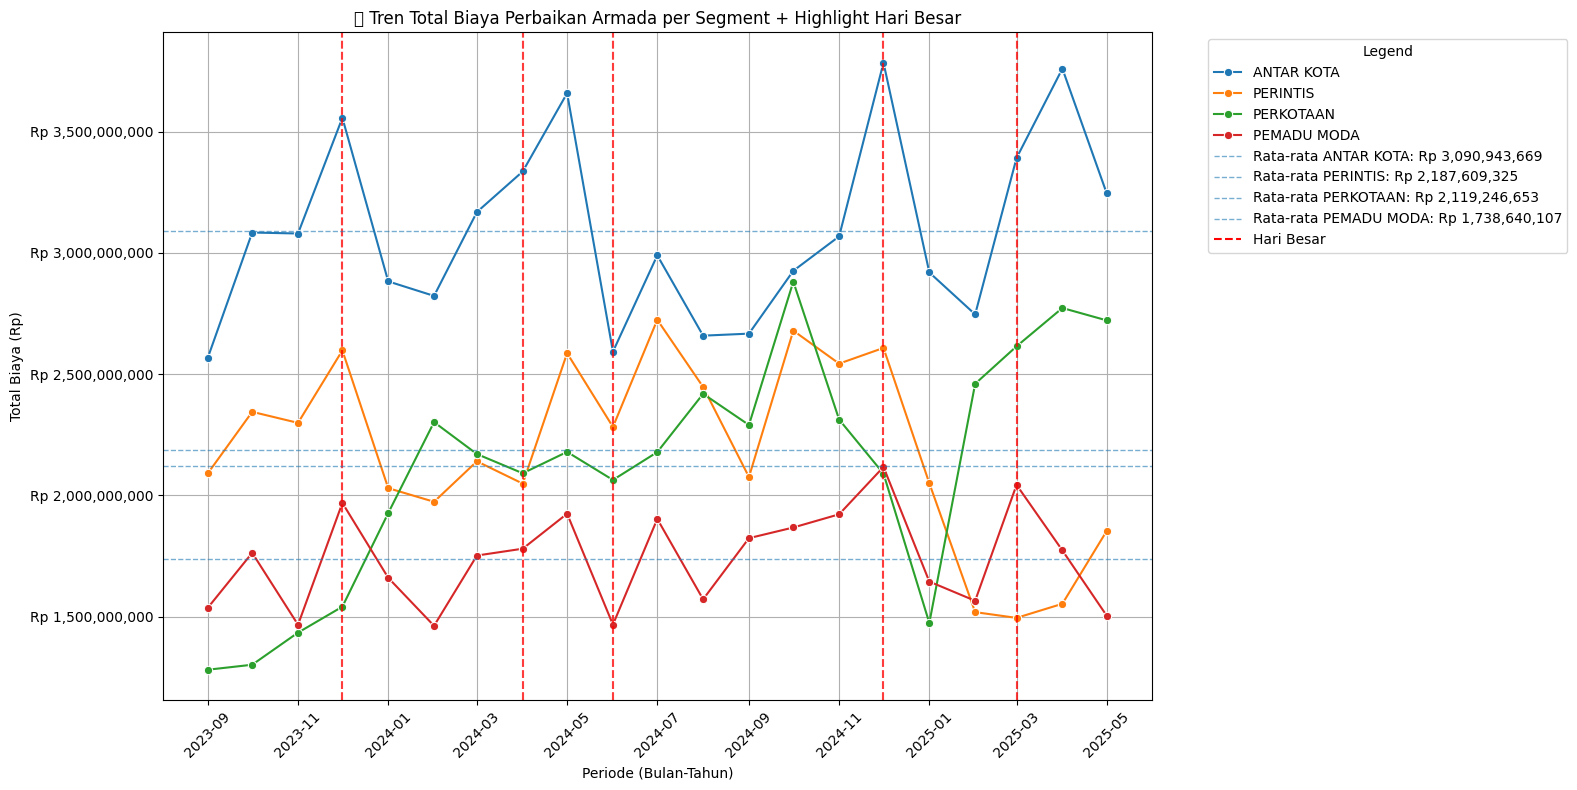

/tmp/ipython-input-3585939718.py:55: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


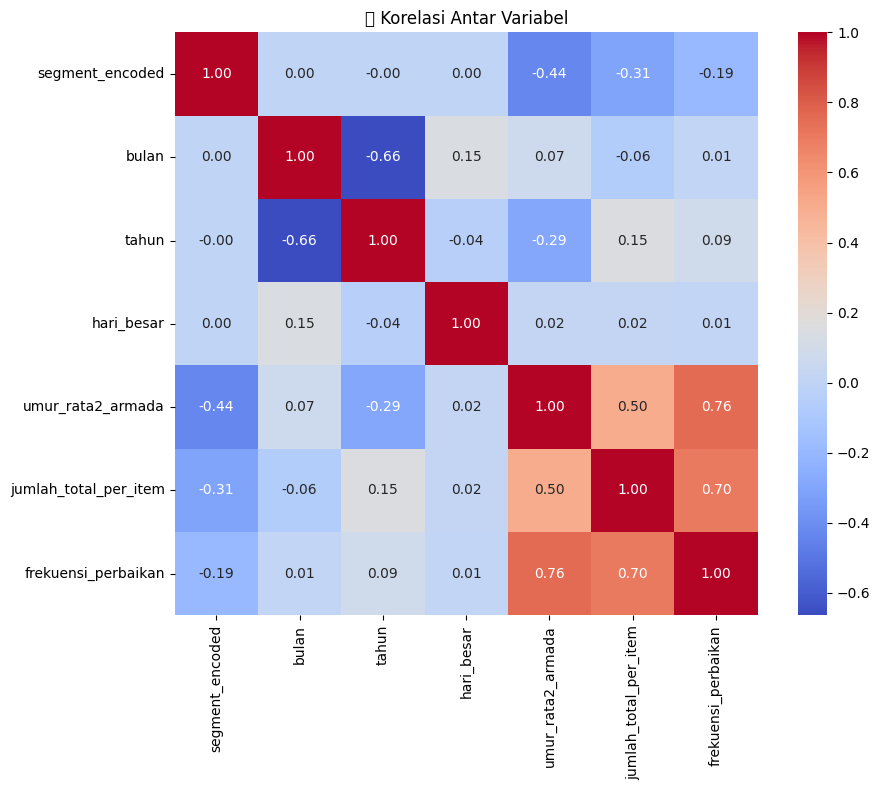

In [6]:
# Periode waktu
df['periode'] = pd.to_datetime(df['bulan'].astype(str).str.zfill(2) + '-' + df['tahun'].astype(str), format='%m-%Y')

# Urutkan segmen dari yang biaya rata-ratanya tertinggi
segment_means = df.groupby('nm_segment')['total_biaya'].mean().sort_values(ascending=False)

plt.figure(figsize=(16, 8))
sns.lineplot(data=df, x='periode', y='total_biaya', hue='nm_segment',
             hue_order=segment_means.index.tolist(), marker='o')

# Tambahkan tanda pada hari besar
df_hb = df[df['hari_besar'] == 1]
for _, row in df_hb.iterrows():
    plt.axvline(x=row['periode'], color='red', linestyle='--', alpha=0.3)
    plt.text(row['periode'], row['total_biaya'] + 1e7, '', rotation=90, color='red', fontsize=8)

# Garis rata-rata per segment
for seg, mean in segment_means.items():
    plt.axhline(y=mean, linestyle='--', linewidth=1, alpha=0.6,
                label=f'Rata-rata {seg}: Rp {mean:,.0f}')

# Menambahkan garis putus-putus merah ke legend
hb_line = mlines.Line2D([], [], color='red', linestyle='--', label='Hari Besar')

plt.title('📊 Tren Total Biaya Perbaikan Armada per Segment + Highlight Hari Besar')
plt.xlabel('Periode (Bulan-Tahun)')
plt.ylabel('Total Biaya (Rp)')
plt.xticks(rotation=45)
plt.grid(True)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'Rp {x:,.0f}'))

# Legend unik + garis putus-putus merah untuk hari besar
handles, labels = plt.gca().get_legend_handles_labels()
handles_unique, labels_unique = [], []
seen = set()
for h, l in zip(handles, labels):
    if l not in seen:
        handles_unique.append(h)
        labels_unique.append(l)
        seen.add(l)
handles_unique.append(hb_line)  # Menambahkan garis hari besar ke legend
labels_unique.append('Hari Besar')  # Label garis hari besar
plt.legend(handles_unique, labels_unique, title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Buat dataframe korelasi
corr = df[feature_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("🔍 Korelasi Antar Variabel")
plt.tight_layout()
plt.show()

/tmp/ipython-input-4005650992.py:7: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


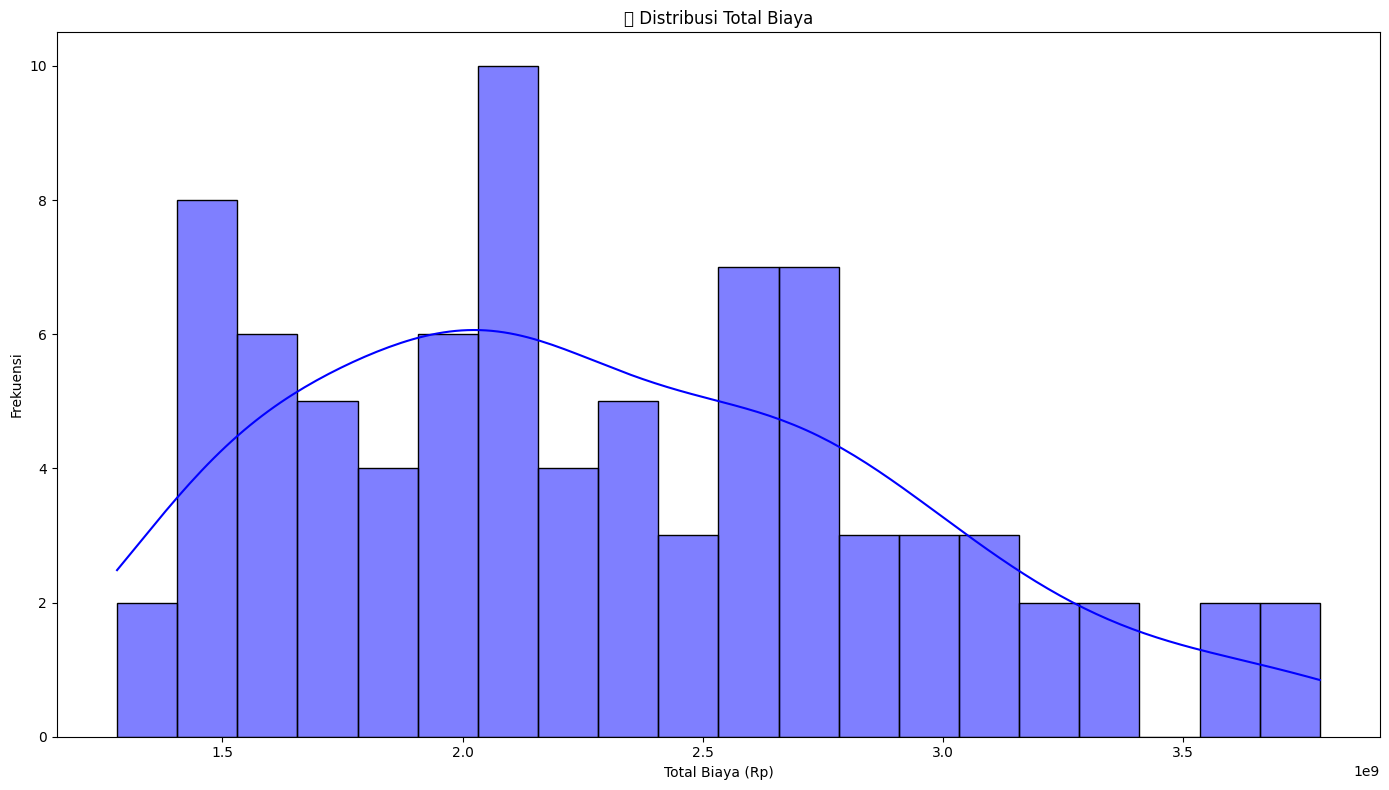

Skewness: 0.48


In [7]:
# Histogram untuk mengecek distribusi total_biaya
plt.figure(figsize=(14, 8))
sns.histplot(df['total_biaya'], bins=20, kde=True, color='blue')
plt.title('📊 Distribusi Total Biaya')
plt.xlabel('Total Biaya (Rp)')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

# Menghitung skewness (nilai > 1 atau < -1 menunjukkan skewness yang signifikan)
skewness = df['total_biaya'].skew()
print(f"Skewness: {skewness:.2f}")

# Tuning Parameter

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definisikan parameter grid untuk tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Inisialisasi model RandomForestRegressor
base_model = RandomForestRegressor(random_state=42)

# GridSearchCV untuk tuning hyperparameter
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid,
                           cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

# Jalankan grid search untuk tuning
grid_search.fit(X_train, y_train)

# Tampilkan parameter terbaik dan hasil tuning
print("=== Hasil Tuning Random Forest ===")
print("Best Parameters:", grid_search.best_params_)
print("Best MAE (CV)  :", -grid_search.best_score_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
=== Hasil Tuning Random Forest ===
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best MAE (CV)  : 153789925.31423163


# Modeling

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# === Latih model final dengan parameter terbaik ===
best_rf = RandomForestRegressor(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    random_state=42
)

# Latih model pada data training
best_rf.fit(X_train, y_train)

# === Prediksi di data test ===
y_pred = best_rf.predict(X_test)

# === Evaluasi ===
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mean_y = y_test.mean()
mae_pct = mae / mean_y * 100
rmse_pct = rmse / mean_y * 100

# === Cetak hasil evaluasi ===
print("=== Evaluasi Model Random Forest (Tuned) ===")
print(f"MAE  : Rp {mae:,.0f} ({mae_pct:.2f}%)")
print(f"RMSE : Rp {rmse:,.0f} ({rmse_pct:.2f}%)")
print(f"R²   : {r2:.4f}")

=== Evaluasi Model Random Forest (Tuned) ===
MAE  : Rp 141,320,552 (6.03%)
RMSE : Rp 162,917,278 (6.95%)
R²   : 0.9156


In [11]:
import joblib
from google.colab import files

# === Simpan model Random Forest ===
joblib.dump(best_rf, "model_rf.pkl")
files.download("model_rf.pkl")

# === Simpan dan download LabelEncoder ===
joblib.dump(le, "label_encoder.pkl")
files.download("label_encoder.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# XGBoost

In [12]:
# Import yang dibutuhkan
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Pastikan data sudah dibagi menjadi training dan testing
# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definisikan parameter grid untuk tuning XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Inisialisasi model XGBoost
xgb_model = xgb.XGBRegressor(random_state=42)

# GridSearchCV untuk tuning XGBoost
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb,
                               cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

# Jalankan grid search untuk XGBoost
grid_search_xgb.fit(X_train, y_train)

# Tampilkan parameter terbaik dan hasil tuning
print("=== Hasil Tuning XGBoost ===")
print("Best Parameters:", grid_search_xgb.best_params_)
print("Best MAE (CV)  :", -grid_search_xgb.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
=== Hasil Tuning XGBoost ===
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best MAE (CV)  : 151799079.76516983


In [13]:
# Latih model final XGBoost dengan parameter terbaik
best_xgb = xgb.XGBRegressor(
    n_estimators=grid_search_xgb.best_params_['n_estimators'],
    max_depth=grid_search_xgb.best_params_['max_depth'],
    learning_rate=grid_search_xgb.best_params_['learning_rate'],
    subsample=grid_search_xgb.best_params_['subsample'],
    colsample_bytree=grid_search_xgb.best_params_['colsample_bytree'],
    random_state=42
)

# Latih model XGBoost
best_xgb.fit(X_train, y_train)

# Prediksi pada data test
y_pred_xgb = best_xgb.predict(X_test)

# Evaluasi XGBoost
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

# Definisikan mean_y untuk perhitungan persentase kesalahan
mean_y = y_test.mean()

# Cetak hasil evaluasi XGBoost
print("=== Evaluasi Model XGBoost (Tuned) ===")
print(f"MAE  : Rp {mae_xgb:,.0f} ({mae_xgb / mean_y * 100:.2f}%)")
print(f"RMSE : Rp {rmse_xgb:,.0f} ({rmse_xgb / mean_y * 100:.2f}%)")
print(f"R²   : {r2_xgb:.4f}")

=== Evaluasi Model XGBoost (Tuned) ===
MAE  : Rp 141,927,717 (6.06%)
RMSE : Rp 177,784,586 (7.59%)
R²   : 0.8995


# HYBRID ML

In [14]:
# Install mealpy jika belum terinstal
!pip install -U mealpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.9/397.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 55.3 MB/s eta 0:00:00


In [15]:
# Import yang diperlukan
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from mealpy import FloatVar
from mealpy.bio_based import SMA
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === SPLIT DATA (dari hasil PCA atau dataset yang Anda punya) ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === FITNESS FUNCTION UNTUK SMA ===
def fitness_function(solution):
    n_estimators = int(solution[0])  # Number of trees
    max_depth = int(solution[1])     # Depth of each tree
    learning_rate = solution[2]      # Learning rate

    # Inisialisasi model XGBoost
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=42
    )

    # Cross-validation untuk mengukur kinerja model
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=3)

    # Mengembalikan nilai fitness (MAE positif)
    return -scores.mean()

# === DEFINISI BOUND VARIABEL UNTUK SMA ===
problem = {
    "obj_func": fitness_function,       # Fungsi fitness untuk optimasi
    "bounds": FloatVar(                 # Batasan nilai untuk n_estimators, max_depth, dan learning_rate
        lb=[50, 3, 0.01],               # Lower bounds [n_estimators, max_depth, learning_rate]
        ub=[500, 10, 0.3],              # Upper bounds
    ),
    "minmax": "min",                    # Menetapkan untuk meminimalkan fungsi fitness
    "log_to": "console",                # Menampilkan hasil di console
}

# === INISIASI DAN JALANKAN OPTIMASI SMA ===
optimizer = SMA.OriginalSMA(epoch=20, pop_size=10)  # Set epoch dan pop_size untuk optimasi
results = optimizer.solve(problem)  # Menjalankan optimasi SMA

# === TAMPILKAN HASIL OPTIMAL ===
best_params = optimizer.g_best.solution   # Parameter terbaik yang ditemukan
best_score = optimizer.g_best.target.fitness  # Skor terbaik (MAE)

print("\n=== HASIL OPTIMASI SMA ===")
print(f"Best n_estimators  : {int(best_params[0])}")
print(f"Best max_depth     : {int(best_params[1])}")
print(f"Best learning_rate : {best_params[2]:.4f}")
print(f"Best MAE (CV)      : {best_score:.2f}")

INFO:mealpy.bio_based.SMA.OriginalSMA:OriginalSMA(epoch=20, pop_size=10, p_t=0.03)
INFO:mealpy.bio_based.SMA.OriginalSMA:>>>Problem: P, Epoch: 1, Current best: 155373351.19706443, Global best: 155373351.19706443, Runtime: 15.53281 seconds
INFO:mealpy.bio_based.SMA.OriginalSMA:>>>Problem: P, Epoch: 2, Current best: 156183996.6990407, Global best: 155373351.19706443, Runtime: 5.55391 seconds
INFO:mealpy.bio_based.SMA.OriginalSMA:>>>Problem: P, Epoch: 3, Current best: 156690956.40495452, Global best: 155373351.19706443, Runtime: 0.73461 seconds
INFO:mealpy.bio_based.SMA.OriginalSMA:>>>Problem: P, Epoch: 4, Current best: 155804464.10314876, Global best: 155373351.19706443, Runtime: 0.79225 seconds
INFO:mealpy.bio_based.SMA.OriginalSMA:>>>Problem: P, Epoch: 5, Current best: 153687568.4560901, Global best: 153687568.4560901, Runtime: 0.93363 seconds
INFO:mealpy.bio_based.SMA.OriginalSMA:>>>Problem: P, Epoch: 6, Current best: 159891875.53983715, Global best: 153687568.4560901, Runtime: 1.6316


=== HASIL OPTIMASI SMA ===
Best n_estimators  : 50
Best max_depth     : 3
Best learning_rate : 0.1794
Best MAE (CV)      : 152832011.98


In [16]:
# === LATIH FINAL MODEL DENGAN PARAMETER TERBAIK ===
best_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=int(best_params[0]),
    max_depth=int(best_params[1]),
    learning_rate=best_params[2],
    random_state=42
)

# Latih model dengan parameter terbaik
best_model.fit(X_train, y_train)

# === PREDIKSI DAN EVALUASI DI DATA TEST ===
y_pred_hybrid = best_model.predict(X_test)

# Evaluasi model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_hybrid))
r2 = r2_score(y_test, y_pred_hybrid)

# Hitung rata-rata nilai aktual (ground truth)
mean_target = y_test.mean()

# Hitung persentase MAE dan RMSE
mae_pct = mae / mean_target * 100
rmse_pct = rmse / mean_target * 100

# === TAMPILKAN HASIL EVALUASI ===
print("\n=== Evaluasi Model XGBoost di Data Test ===")
print(f"MAE  : Rp {mae:,.0f} ({mae_pct:.2f}%)")
print(f"RMSE : Rp {rmse:,.0f} ({rmse_pct:.2f}%)")
print(f"R²   : {r2:.4f}")


=== Evaluasi Model XGBoost di Data Test ===
MAE  : Rp 141,320,552 (6.03%)
RMSE : Rp 179,953,983 (7.68%)
R²   : 0.8970


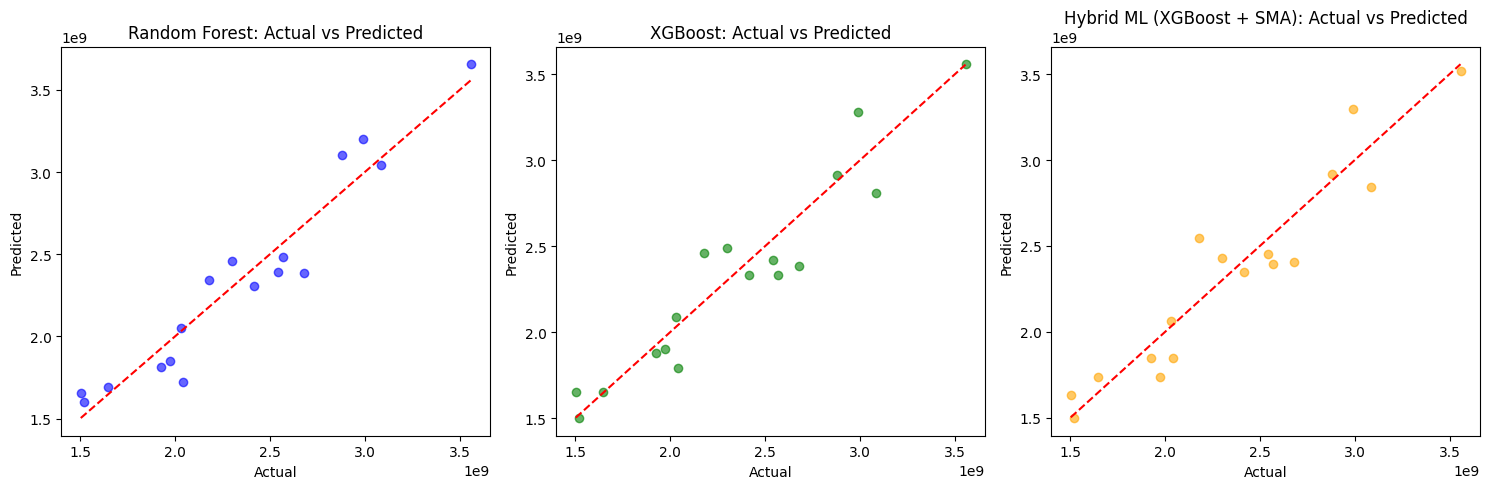

In [17]:
import matplotlib.pyplot as plt

# Prediksi untuk masing-masing model (pastikan y_pred_rf, y_pred_xgb, y_pred_hybrid sudah ada)
# Misalnya, jika Anda sudah melatih model dan mendapatkan prediksi:
# y_pred_rf = best_rf.predict(X_test)
# y_pred_xgb = best_xgb.predict(X_test)
# y_pred_hybrid = best_model.predict(X_test)

# Buat figure dan axes
plt.figure(figsize=(15, 5))

# Subplot untuk Random Forest
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Subplot untuk XGBoost
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_xgb, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('XGBoost: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Subplot untuk Hybrid ML (XGBoost + SMA)
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_hybrid, color='orange', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Hybrid ML (XGBoost + SMA): Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Layout untuk memperbaiki tampilan grafik
plt.tight_layout()

# Tampilkan plot
plt.show()